# **Import Library**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow -q

In [3]:
# Library untuk manipulasi data dan analisis numerik
import pandas as pd
import numpy as np

# Library untuk plotting dan visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk operasi sistem, manipulasi file dan direktori, serta handling file zip
import zipfile
import os
import shutil

# Library untuk augmentasi dan preprocessing gambar pada deep learning dengan Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Library untuk mengabaikan peringatan agar output lebih bersih
import warnings
warnings.filterwarnings('ignore')

# Library untuk progress bar saat iterasi panjang
from tqdm import tqdm

# Library untuk permodelan DL
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0

In [4]:
tf.__version__

'2.18.0'

# **Loading Dataset**

In [5]:
zip_path = '/content/drive/MyDrive/CC25-CF173 Drive/Dataset/Hijabist-datasets/new-aug-fs-hijabist1000.zip'
extract_path = './'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  print(f"Mengekstrak {zip_path} ke {extract_path}...")
  zip_ref.extractall(extract_path)
  print("Ekstraksi selesai.")

Mengekstrak /content/drive/MyDrive/CC25-CF173 Drive/Dataset/Hijabist-datasets/new-aug-fs-hijabist1000.zip ke ./...
Ekstraksi selesai.


In [6]:
# Direktori dataset
train_dir = "/content/dataset-face-shape_split/train"
val_dir = "/content/dataset-face-shape_split/val"

# **Data Generator Setup**

In [7]:
# Data generator untuk training
train_datagen = ImageDataGenerator(rescale=1./255)

# Data generator untuk validasi
val_datagen = ImageDataGenerator(rescale=1./255)

# Generator training
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224), # Ukuran input default ResNet50
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

# Generator validasi
val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 5000 images belonging to 5 classes.
Found 999 images belonging to 5 classes.


In [8]:
print(f"jumlah kelas :", len(train_generator.class_indices))
print(train_generator.class_indices)  # Mengecek jumlah kelas yang dikenali

jumlah kelas : 5
{'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}


# **Modelling**

In [9]:
# Menggunakan pretrained model sebagai base model, tanpa top
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Set semua layer agar bisa di-fine-tune
for layer in base_model.layers:
    layer.trainable = True

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Bangun model akhir
model = Model(inputs=base_model.input, outputs=output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
# Tampilkan arsitektur model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 2,388,485 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [11]:
model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('model_best.keras', save_best_only=True, monitor='val_loss', verbose=1)
]

In [13]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.4031 - loss: 1.4638
Epoch 1: val_loss improved from inf to 6.12378, saving model to model_best.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 103s 305ms/step - accuracy: 0.4038 - loss: 1.4621 - val_accuracy: 0.2723 - val_loss: 6.1238 - learning_rate: 0.0010
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7176 - loss: 0.7766
Epoch 2: val_loss did not improve from 6.12378
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - accuracy: 0.7176 - loss: 0.7765 - val_accuracy: 0.2603 - val_loss: 6.1600 - learning_rate: 0.0010
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8230 - loss: 0.5231
Epoch 3: val_loss improved from 6.12378 to 4.82839, saving model to model_best.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.8230 - loss: 0.5233 - val_accuracy: 0.3894 - val_loss: 4.8284 - learning_rate: 0.0010
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8688 - loss: 0.3781
Ep

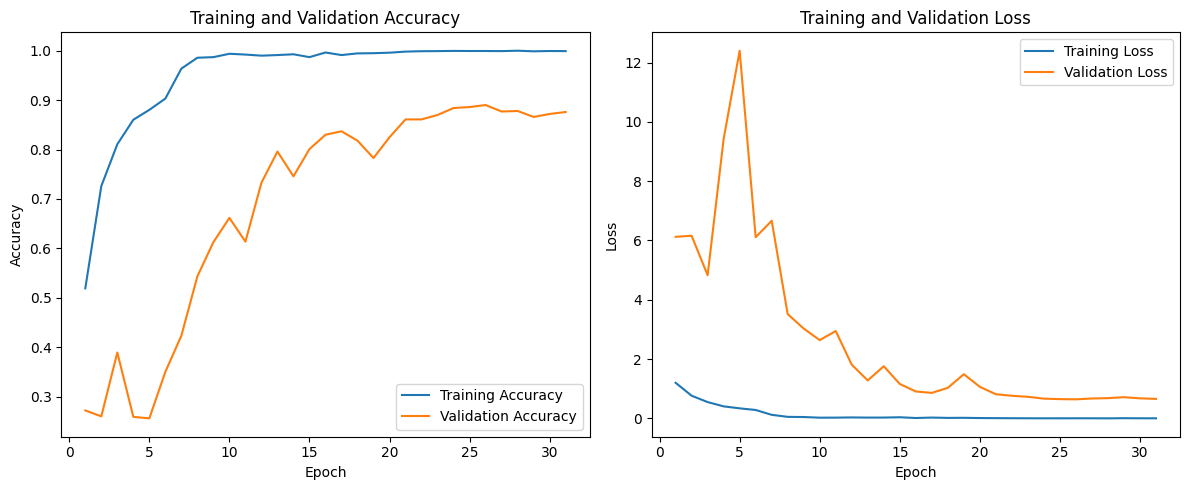

In [14]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Panggil fungsi ini setelah training
plot_training_history(history)

In [16]:
# Prediksi di data validasi
val_generator.reset()
pred_probs = model.predict(val_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# metrik evaluasi
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\n Evaluasi Model:")
print(f" - Accuracy : {acc:.4f}")
print(f" - Precision: {prec:.4f}")
print(f" - Recall   : {rec:.4f}")
print(f" - F1-Score : {f1:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step

 Evaluasi Model:
 - Accuracy : 0.8899
 - Precision: 0.8913
 - Recall   : 0.8899
 - F1-Score : 0.8901



 Classification Report:
              precision    recall  f1-score   support

       Heart       0.88      0.91      0.89       200
      Oblong       0.95      0.92      0.93       200
        Oval       0.85      0.82      0.83       200
       Round       0.84      0.89      0.86       199
      Square       0.95      0.91      0.93       200

    accuracy                           0.89       999
   macro avg       0.89      0.89      0.89       999
weighted avg       0.89      0.89      0.89       999



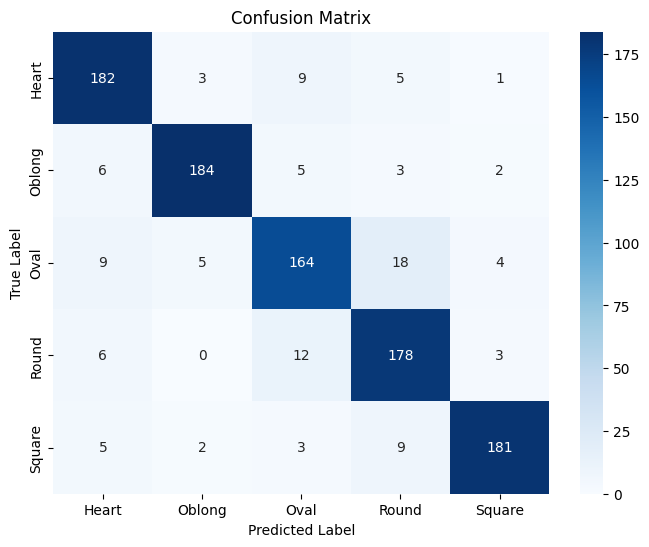

In [17]:
# Classification report
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [18]:
labels = list(train_generator.class_indices.keys())
with open('labels.txt', 'w') as f:
  for item in labels:
    f.write("%s\n" % item)

# **Inference**

In [19]:
# Library untuk Inference and Utility
import cv2
import dlib
from PIL import Image
from tensorflow.keras.models import load_model
from google.colab import files
import urllib.request
import bz2

In [20]:
url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
bz2_path = 'shape_predictor_68_face_landmarks.dat.bz2'
dat_path = 'shape_predictor_68_face_landmarks.dat'

# Download jika belum ada
if not os.path.exists(dat_path):
    print("Downloading predictor...")
    urllib.request.urlretrieve(url, bz2_path)

    print("Extracting predictor...")
    with bz2.BZ2File(bz2_path) as fr, open(dat_path, 'wb') as fw:
        fw.write(fr.read())

    os.remove(bz2_path)
    print("Done.")
else:
    print("Predictor file already exists.")

Extracting predictor...
Done.


In [21]:
# Inisialisasi detektor wajah dlib
# dlib akan digunakan untuk mendeteksi lokasi wajah.
try:
    detector = dlib.get_frontal_face_detector()
    print("Detektor dlib berhasil diinisialisasi.")
except Exception as e:
    print(f"Gagal menginisialisasi dlib face detector: {e}")
    detector = None # Set detector menjadi None jika gagal

# Muat model terbaik yang sudah dilatih
model_path_keras = '/content/model_best.keras'  # Path untuk model format Keras v3
model = None

if detector:
    try:
        model = tf.keras.models.load_model(model_path_keras)
        print(f"Model berhasil dimuat dari {model_path_keras}")
    except Exception as e_keras:
        print(f"Gagal memuat model dari {model_path_keras}: {e_keras}")
else:
    print("Detektor wajah tidak terinisialisasi, proses inferensi tidak dapat dilanjutkan tanpa deteksi wajah.")

Detektor dlib berhasil diinisialisasi.
Model berhasil dimuat dari /content/model_best.keras


In [22]:
# Mapping indeks kelas ke nama kelas dari file labels.txt
labels_file_path = '/content/labels.txt'
class_labels = []

with open(labels_file_path, 'r') as f:
    for line in f:
        class_labels.append(line.strip())

# Ukuran gambar yang digunakan untuk pelatihan model
target_size = (224, 224)

In [78]:
def resize_with_padding(img_pil, target_size=(224, 224), bg_color=(0, 0, 0)):
    """
    Resize gambar PIL dengan mempertahankan rasio aspek dan menambahkan padding.
    """
    original_size = img_pil.size  # (width, height)
    ratio = min(target_size[0] / original_size[0], target_size[1] / original_size[1])
    new_size = (int(original_size[0] * ratio), int(original_size[1] * ratio))

    resample_method = Image.Resampling.LANCZOS if hasattr(Image, 'Resampling') else Image.LANCZOS
    img_resized = img_pil.resize(new_size, resample_method)

    new_img = Image.new("RGB", target_size, bg_color)
    paste_position = ((target_size[0] - new_size[0]) // 2,
                      (target_size[1] - new_size[1]) // 2)
    new_img.paste(img_resized, paste_position)
    return new_img

def preprocess_image(image_path, detector_dlib, predictor_path, target_size_tuple=(224, 224)):
    """
    Melakukan preprocessing lengkap pada satu gambar untuk inferensi:
    - CLAHE
    - Deteksi wajah
    - Cropping wajah berdasarkan landmark (dengan square crop)
    - Resize + padding ke target_size
    - Menggunakan preprocessing_function dari model (e.g., resnet_preprocess_input)
    - Expand dims
    """
    try:
        # Inisialisasi predictor
        predictor = dlib.shape_predictor(predictor_path)

        # Baca dan validasi gambar
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Gambar tidak bisa dibaca dari {image_path}")
            return None

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # CLAHE untuk meningkatkan kontras
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_gray = clahe.apply(gray)

        faces = detector_dlib(enhanced_gray, 1)  # upsampling=1

        if not faces:
            print(f"Peringatan: Tidak ada wajah terdeteksi pada {os.path.basename(image_path)}")
            return None

        face = faces[0]
        landmarks = predictor(enhanced_gray, face)
        points = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(68)])

        jaw = points[0:17]
        chin = points[8]
        nose_bridge_top = points[27]
        left_eyebrow_outer = points[17]
        right_eyebrow_outer = points[26]

        # Estimasi dahi
        face_height_to_nose = chin[1] - nose_bridge_top[1]
        if face_height_to_nose <= 0:
            face_height_to_nose = 1
        forehead_top_y = max(0, nose_bridge_top[1] - int(face_height_to_nose * 0.7))

        padding = 25
        x1 = min(jaw[:, 0].min(), left_eyebrow_outer[0]) - padding
        x2 = max(jaw[:, 0].max(), right_eyebrow_outer[0]) + padding
        y1 = forehead_top_y - padding
        y2 = chin[1] + padding

        # Square crop
        width = x2 - x1
        height = y2 - y1
        side = max(width, height)
        center_x = (x1 + x2) // 2
        center_y = (y1 + y2) // 2

        x1 = max(0, center_x - side // 2)
        x2 = min(img.shape[1], center_x + side // 2)
        y1 = max(0, center_y - side // 2)
        y2 = min(img.shape[0], center_y + side // 2)

        if x1 >= x2 or y1 >= y2:
            print(f"Peringatan: Ukuran cropping tidak valid pada {os.path.basename(image_path)}")
            return None

        cropped_img = img[y1:y2, x1:x2]
        if cropped_img.size == 0:
            print(f"Peringatan: Area cropping kosong untuk {os.path.basename(image_path)}")
            return None

        # Konversi BGR ke RGB dan resize + padding
        cropped_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        pil_cropped = Image.fromarray(cropped_rgb)
        resized_padded = resize_with_padding(pil_cropped, target_size=target_size_tuple)

        # Normalisasi dan tambahkan dimensi batch
        img_array = np.array(resized_padded).astype('float32') / 255.0
        return np.expand_dims(img_array, axis=0)

    except Exception as e:
        print(f"Error saat memproses gambar {os.path.basename(image_path)}: {e}")
        return None

In [24]:
def predict_face_shape(image_path, model_loaded, class_labels_list, detector_for_preprocess, predictor_path_for_preprocess, target_size_tuple=(224, 224)):
    """
    Memproses gambar baru, melakukan prediksi face shape menggunakan model,
    dan menampilkan hasil prediksi beserta gambar asli & gambar yang telah diproses.
    """
    if model_loaded is None:
        print("Error: Model belum berhasil dimuat. Tidak bisa melakukan prediksi face shape.")
        return
    if detector_for_preprocess is None:
        print("Error: Detektor dlib tidak tersedia untuk preprocessing.")
        return
    if predictor_path_for_preprocess is None:
        print("Error: Path predictor dlib tidak tersedia untuk preprocessing.")
        return

    print(f"Memproses gambar untuk prediksi face shape: {os.path.basename(image_path)}...")

    # Simpan versi asli untuk ditampilkan nanti
    try:
        original_image_pil = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Gagal membuka gambar original: {e}")
        return

    # Preprocessing
    processed_image_batch = preprocess_image(
        image_path,
        detector_for_preprocess,
        predictor_path_for_preprocess,
        target_size_tuple
    )

    if processed_image_batch is None:
        print("Preprocessing gambar gagal. Tidak bisa melanjutkan prediksi face shape.")
        # Tetap tampilkan gambar original sebagai referensi
        plt.figure(figsize=(5, 5))
        plt.imshow(original_image_pil)
        plt.title(f"Original Image (Preprocessing Gagal):\n{os.path.basename(image_path)}")
        plt.axis('off')
        plt.show()
        return

    # Prediksi
    print("Melakukan prediksi face shape...")
    predictions_batch = model_loaded.predict(processed_image_batch)
    predictions_single = predictions_batch[0]
    predicted_class_index = np.argmax(predictions_single)

    if not class_labels_list or predicted_class_index >= len(class_labels_list):
        predicted_label = "Tidak Diketahui (Indeks Kelas Invalid)"
        print(f"Peringatan: Indeks kelas prediksi ({predicted_class_index}) di luar jangkauan class_labels_list ({len(class_labels_list)})")
    else:
        predicted_label = class_labels_list[predicted_class_index]

    print(f"Hasil Prediksi Face Shape: {predicted_label} (Probabilitas: {predictions_single[predicted_class_index]:.4f})")

    print("Probabilitas per kelas:")
    for i, prob in enumerate(predictions_single):
        label = class_labels_list[i] if i < len(class_labels_list) else f"Kelas_{i}"
        print(f"  - {label}: {prob:.4f}")

    # Tampilkan gambar original & processed side by side
    try:
        processed_img_display = (processed_image_batch[0] * 255).astype(np.uint8)

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Gambar asli
        axs[0].imshow(original_image_pil)
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        # Gambar yang diproses
        axs[1].imshow(processed_img_display)
        axs[1].set_title(f"Processed Image\nPrediction: {predicted_label}")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()
    except Exception as e_disp:
        print(f"Gagal menampilkan gambar: {e_disp}")

In [25]:
def upload_and_predict_colab(model_to_use, labels_list, detector_obj, predictor_path_obj, size_tuple=(224, 224)):
    """
    Meminta pengguna mengunggah satu atau beberapa gambar melalui antarmuka Colab,
    menyimpannya sementara, melakukan prediksi, lalu menghapusnya.
    """
    if model_to_use is None or detector_obj is None or predictor_path_obj is None:
        print("Model, Detektor dlib, atau Predictor dlib belum siap. Unggah dibatalkan.")
        return

    print("Silakan unggah gambar Anda (bisa lebih dari satu):")
    try:
        uploaded_files_dict = files.upload() # Menampilkan dialog upload Colab

        if not uploaded_files_dict:
            print("Tidak ada file yang diunggah.")
            return

        for file_name in uploaded_files_dict.keys():
            print(f'\nMemproses file unggahan: "{file_name}" ({len(uploaded_files_dict[file_name])} bytes)')

            # Simpan file yang diunggah ke _file system_ sementara Colab agar bisa dibaca path-nya
            temp_image_path = file_name
            with open(temp_image_path, 'wb') as f:
                f.write(uploaded_files_dict[file_name])

            # Lakukan prediksi pada gambar yang diunggah
            predict_face_shape(temp_image_path, model_to_use, labels_list, detector_obj, predictor_path_obj, size_tuple)

            # Hapus file lokal setelah selesai diproses (opsional, untuk kebersihan)
            try:
                os.remove(temp_image_path)
                print(f"File sementara '{temp_image_path}' telah dihapus.")
            except Exception as e_remove:
                print(f"Gagal menghapus file sementara '{temp_image_path}': {e_remove}")
    except Exception as e_upload:
        print(f"Terjadi error saat proses unggah atau prediksi: {e_upload}")


 MEMULAI SESI UNGGAH DAN PREDIKSI GAMBAR BARU 
Silakan unggah gambar Anda (bisa lebih dari satu):


Saving F201302251003401592418921.jpg to F201302251003401592418921.jpg
Saving heart.jpeg to heart.jpeg
Saving heart2.jpg to heart2.jpg
Saving hijab-round.jpg to hijab-round.jpg
Saving Oblong-Face.jpg to Oblong-Face.jpg
Saving oblongss.jpeg to oblongss.jpeg
Saving oval.jpg to oval.jpg
Saving round-selfie-3.webp to round-selfie-3.webp
Saving Screenshot 2025-05-25 121114.png to Screenshot 2025-05-25 121114.png
Saving Screenshot 2025-05-25 121419.png to Screenshot 2025-05-25 121419.png
Saving Screenshot 2025-05-25 121805.png to Screenshot 2025-05-25 121805.png
Saving short-hairstyles-for-oblong-faces-winsome-12-amazing-the-face-shape-13-gallery.webp to short-hairstyles-for-oblong-faces-winsome-12-amazing-the-face-shape-13-gallery.webp
Saving square.jpeg to square.jpeg
Saving square.jpg to square.jpg
Saving squarex.jpeg to squarex.jpeg

Memproses file unggahan: "F201302251003401592418921.jpg" (43668 bytes)
Memproses gambar untuk prediksi face shape: F201302251003401592418921.jpg...
Melakukan

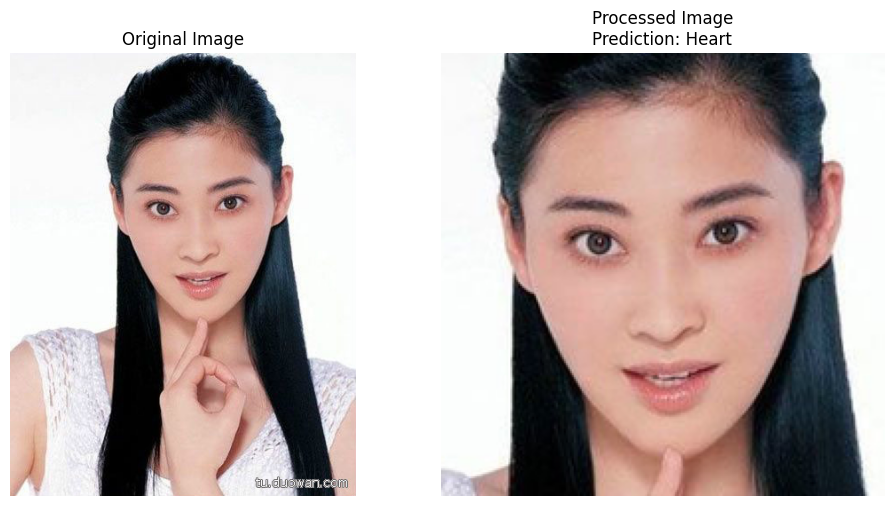

File sementara 'F201302251003401592418921.jpg' telah dihapus.

Memproses file unggahan: "heart.jpeg" (9258 bytes)
Memproses gambar untuk prediksi face shape: heart.jpeg...
Melakukan prediksi face shape...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Hasil Prediksi Face Shape: Heart (Probabilitas: 0.9958)
Probabilitas per kelas:
  - Heart: 0.9958
  - Oblong: 0.0001
  - Oval: 0.0032
  - Round: 0.0005
  - Square: 0.0003


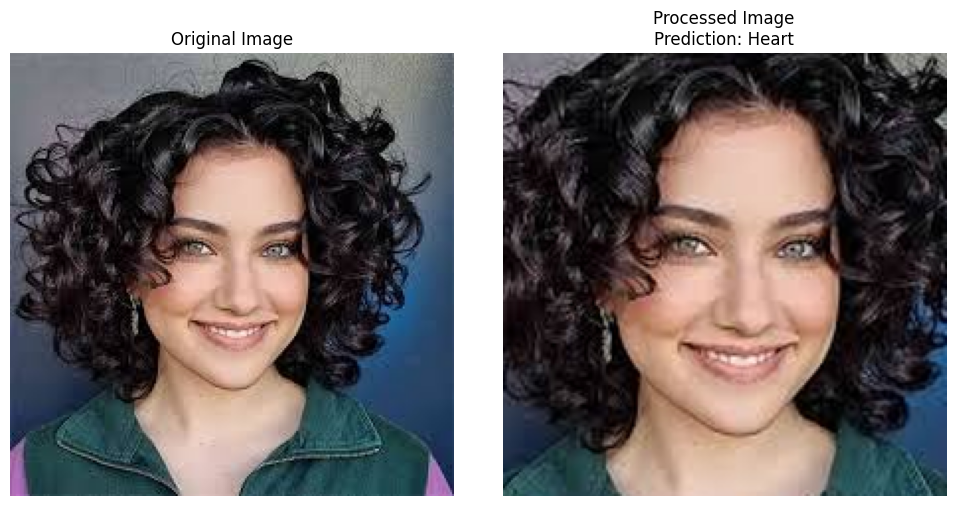

File sementara 'heart.jpeg' telah dihapus.

Memproses file unggahan: "heart2.jpg" (690940 bytes)
Memproses gambar untuk prediksi face shape: heart2.jpg...
Melakukan prediksi face shape...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Hasil Prediksi Face Shape: Heart (Probabilitas: 0.9942)
Probabilitas per kelas:
  - Heart: 0.9942
  - Oblong: 0.0000
  - Oval: 0.0000
  - Round: 0.0001
  - Square: 0.0057


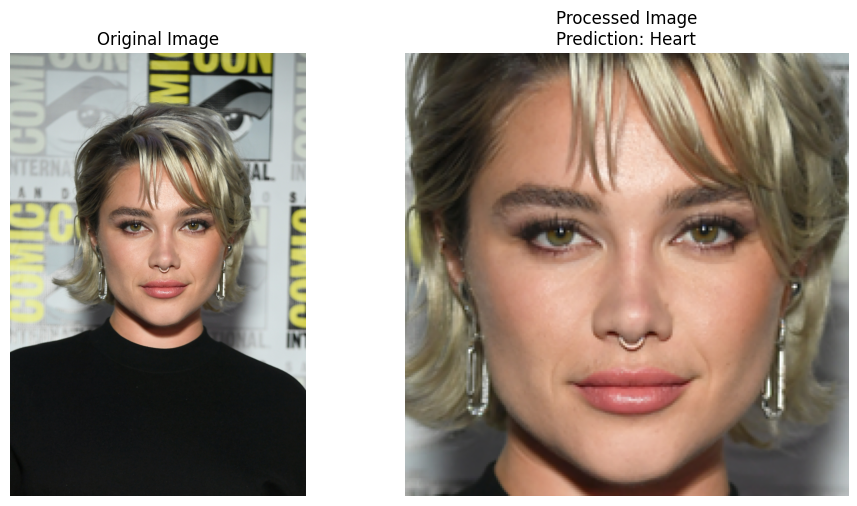

File sementara 'heart2.jpg' telah dihapus.

Memproses file unggahan: "hijab-round.jpg" (46464 bytes)
Memproses gambar untuk prediksi face shape: hijab-round.jpg...
Melakukan prediksi face shape...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Hasil Prediksi Face Shape: Round (Probabilitas: 1.0000)
Probabilitas per kelas:
  - Heart: 0.0000
  - Oblong: 0.0000
  - Oval: 0.0000
  - Round: 1.0000
  - Square: 0.0000


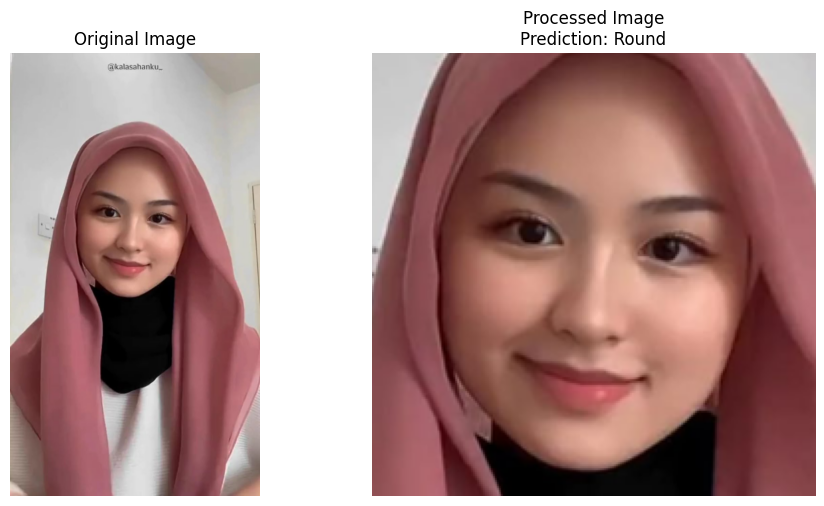

File sementara 'hijab-round.jpg' telah dihapus.

Memproses file unggahan: "Oblong-Face.jpg" (35239 bytes)
Memproses gambar untuk prediksi face shape: Oblong-Face.jpg...
Melakukan prediksi face shape...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Hasil Prediksi Face Shape: Oblong (Probabilitas: 0.4650)
Probabilitas per kelas:
  - Heart: 0.0007
  - Oblong: 0.4650
  - Oval: 0.1051
  - Round: 0.4276
  - Square: 0.0015


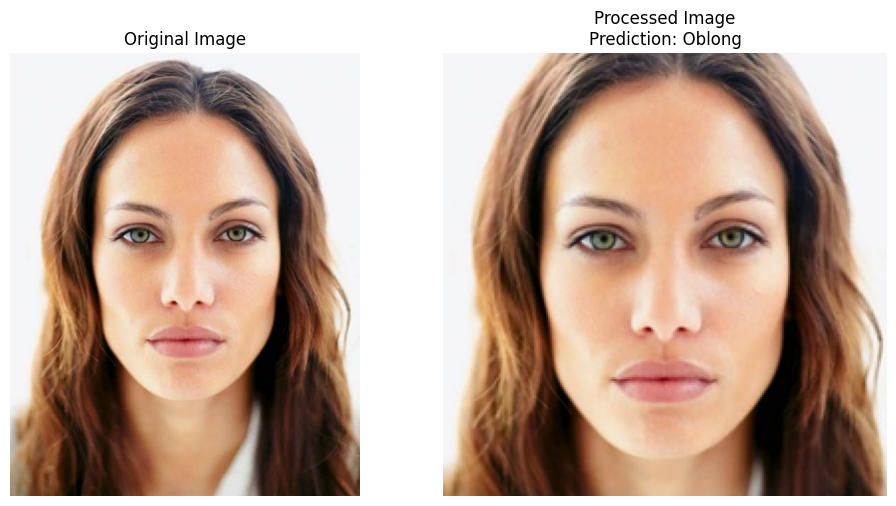

File sementara 'Oblong-Face.jpg' telah dihapus.

Memproses file unggahan: "oblongss.jpeg" (8086 bytes)
Memproses gambar untuk prediksi face shape: oblongss.jpeg...
Melakukan prediksi face shape...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Hasil Prediksi Face Shape: Oblong (Probabilitas: 0.9999)
Probabilitas per kelas:
  - Heart: 0.0000
  - Oblong: 0.9999
  - Oval: 0.0001
  - Round: 0.0000
  - Square: 0.0000


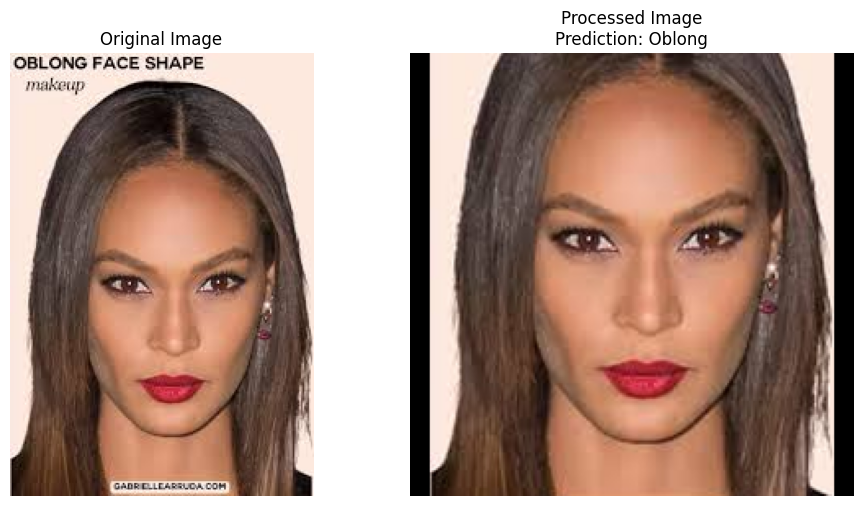

File sementara 'oblongss.jpeg' telah dihapus.

Memproses file unggahan: "oval.jpg" (285894 bytes)
Memproses gambar untuk prediksi face shape: oval.jpg...
Melakukan prediksi face shape...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Hasil Prediksi Face Shape: Oval (Probabilitas: 0.7118)
Probabilitas per kelas:
  - Heart: 0.1025
  - Oblong: 0.1857
  - Oval: 0.7118
  - Round: 0.0000
  - Square: 0.0000


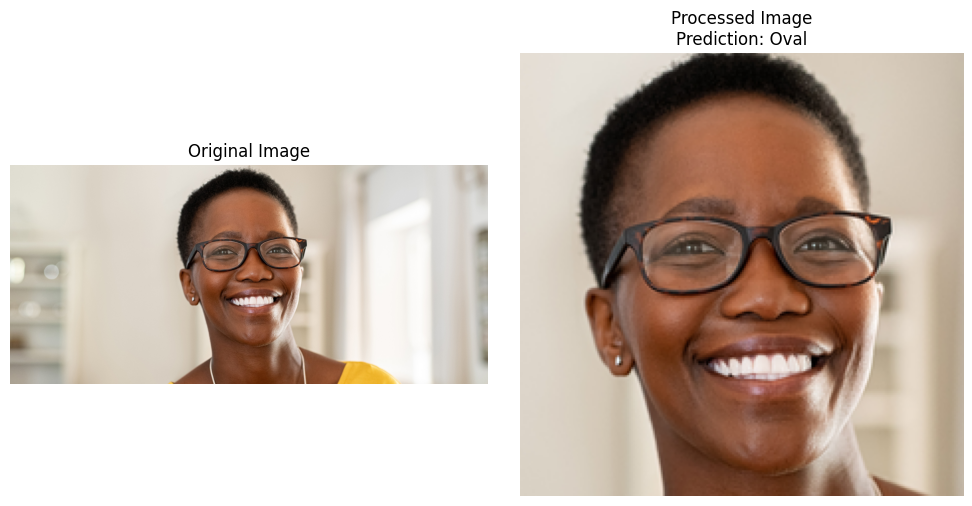

File sementara 'oval.jpg' telah dihapus.

Memproses file unggahan: "round-selfie-3.webp" (42932 bytes)
Memproses gambar untuk prediksi face shape: round-selfie-3.webp...
Melakukan prediksi face shape...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Hasil Prediksi Face Shape: Round (Probabilitas: 0.9999)
Probabilitas per kelas:
  - Heart: 0.0000
  - Oblong: 0.0000
  - Oval: 0.0000
  - Round: 0.9999
  - Square: 0.0001


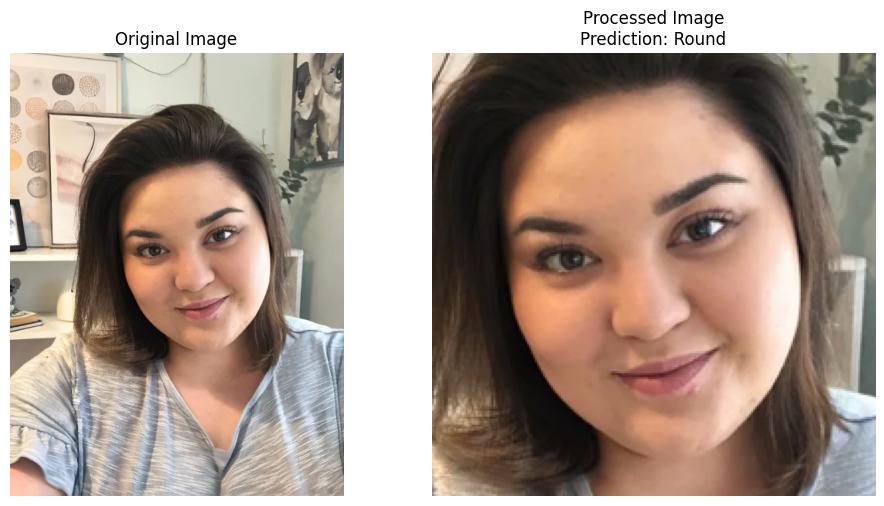

File sementara 'round-selfie-3.webp' telah dihapus.

Memproses file unggahan: "Screenshot 2025-05-25 121114.png" (787313 bytes)
Memproses gambar untuk prediksi face shape: Screenshot 2025-05-25 121114.png...
Melakukan prediksi face shape...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Hasil Prediksi Face Shape: Round (Probabilitas: 1.0000)
Probabilitas per kelas:
  - Heart: 0.0000
  - Oblong: 0.0000
  - Oval: 0.0000
  - Round: 1.0000
  - Square: 0.0000


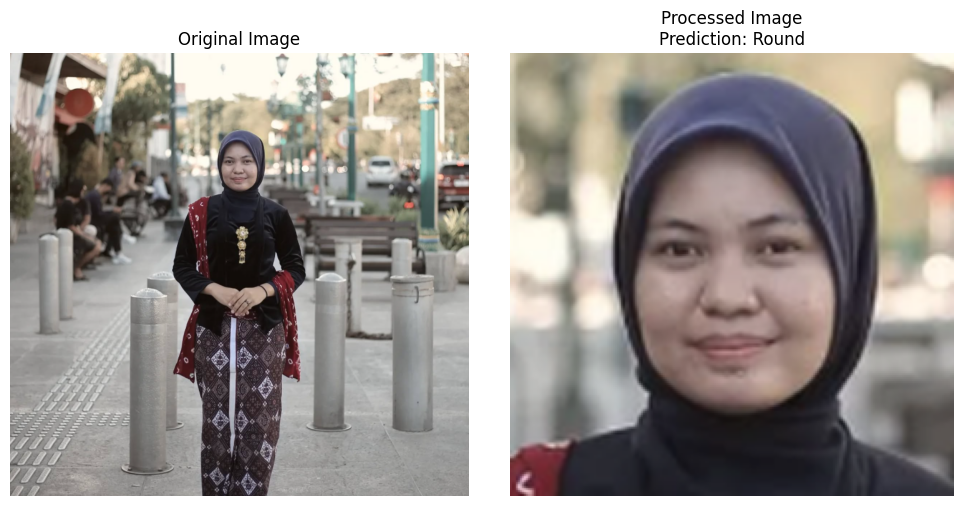

File sementara 'Screenshot 2025-05-25 121114.png' telah dihapus.

Memproses file unggahan: "Screenshot 2025-05-25 121419.png" (548605 bytes)
Memproses gambar untuk prediksi face shape: Screenshot 2025-05-25 121419.png...
Melakukan prediksi face shape...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Hasil Prediksi Face Shape: Oblong (Probabilitas: 0.8323)
Probabilitas per kelas:
  - Heart: 0.0003
  - Oblong: 0.8323
  - Oval: 0.0195
  - Round: 0.1478
  - Square: 0.0000


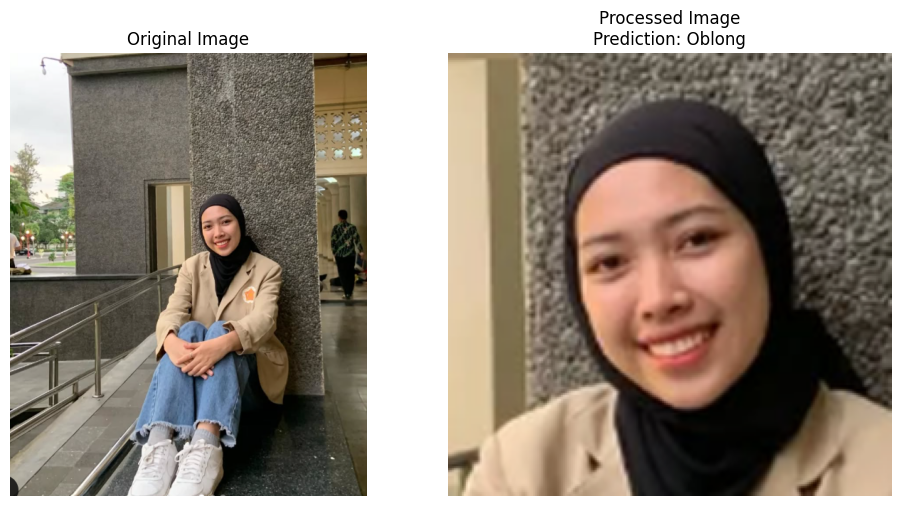

File sementara 'Screenshot 2025-05-25 121419.png' telah dihapus.

Memproses file unggahan: "Screenshot 2025-05-25 121805.png" (376091 bytes)
Memproses gambar untuk prediksi face shape: Screenshot 2025-05-25 121805.png...
Melakukan prediksi face shape...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Hasil Prediksi Face Shape: Round (Probabilitas: 0.9999)
Probabilitas per kelas:
  - Heart: 0.0000
  - Oblong: 0.0000
  - Oval: 0.0001
  - Round: 0.9999
  - Square: 0.0000


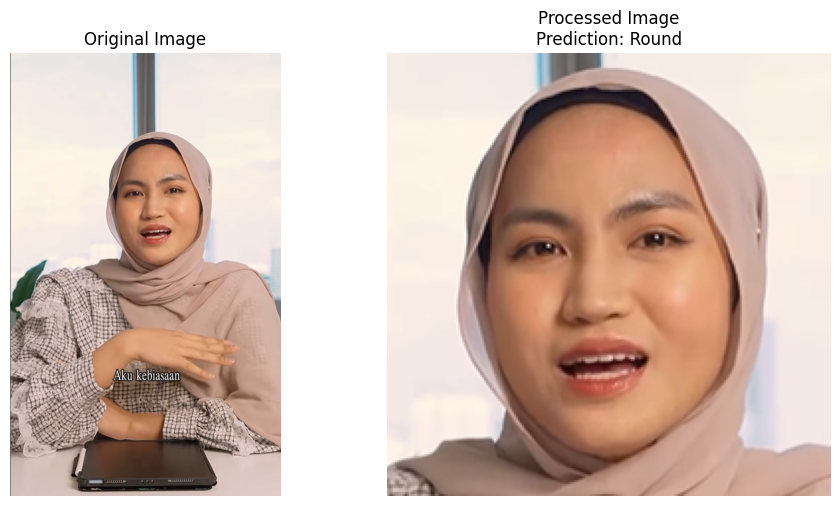

File sementara 'Screenshot 2025-05-25 121805.png' telah dihapus.

Memproses file unggahan: "short-hairstyles-for-oblong-faces-winsome-12-amazing-the-face-shape-13-gallery.webp" (456402 bytes)
Memproses gambar untuk prediksi face shape: short-hairstyles-for-oblong-faces-winsome-12-amazing-the-face-shape-13-gallery.webp...
Melakukan prediksi face shape...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Hasil Prediksi Face Shape: Oblong (Probabilitas: 0.9925)
Probabilitas per kelas:
  - Heart: 0.0000
  - Oblong: 0.9925
  - Oval: 0.0074
  - Round: 0.0000
  - Square: 0.0000


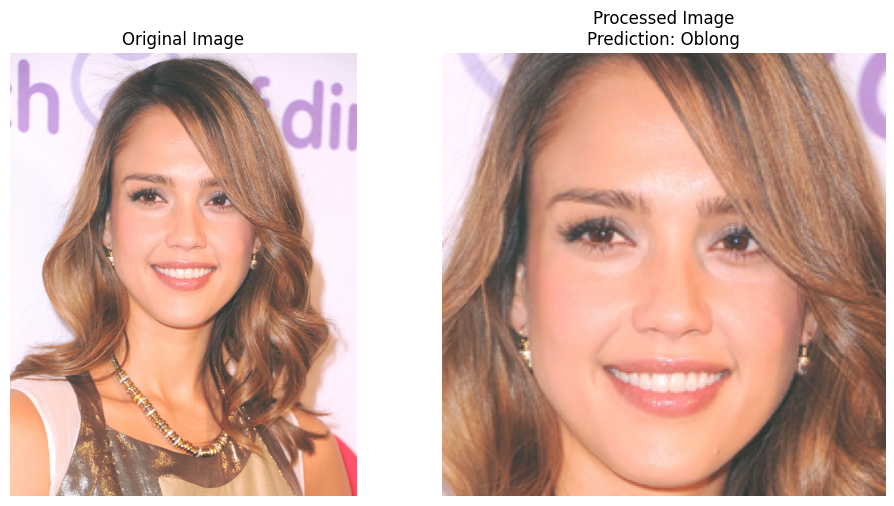

File sementara 'short-hairstyles-for-oblong-faces-winsome-12-amazing-the-face-shape-13-gallery.webp' telah dihapus.

Memproses file unggahan: "square.jpeg" (5406 bytes)
Memproses gambar untuk prediksi face shape: square.jpeg...
Melakukan prediksi face shape...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Hasil Prediksi Face Shape: Square (Probabilitas: 1.0000)
Probabilitas per kelas:
  - Heart: 0.0000
  - Oblong: 0.0000
  - Oval: 0.0000
  - Round: 0.0000
  - Square: 1.0000


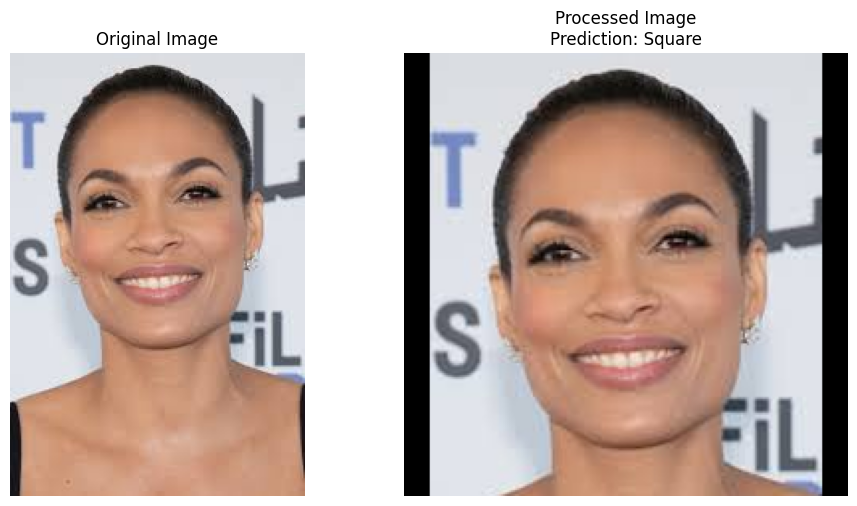

File sementara 'square.jpeg' telah dihapus.

Memproses file unggahan: "square.jpg" (80133 bytes)
Memproses gambar untuk prediksi face shape: square.jpg...
Melakukan prediksi face shape...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Hasil Prediksi Face Shape: Square (Probabilitas: 1.0000)
Probabilitas per kelas:
  - Heart: 0.0000
  - Oblong: 0.0000
  - Oval: 0.0000
  - Round: 0.0000
  - Square: 1.0000


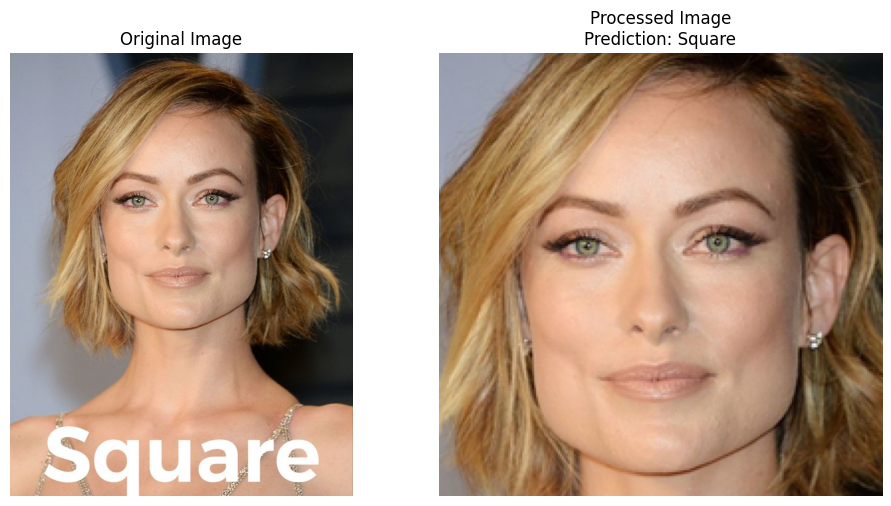

File sementara 'square.jpg' telah dihapus.

Memproses file unggahan: "squarex.jpeg" (6828 bytes)
Memproses gambar untuk prediksi face shape: squarex.jpeg...
Melakukan prediksi face shape...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Hasil Prediksi Face Shape: Square (Probabilitas: 1.0000)
Probabilitas per kelas:
  - Heart: 0.0000
  - Oblong: 0.0000
  - Oval: 0.0000
  - Round: 0.0000
  - Square: 1.0000


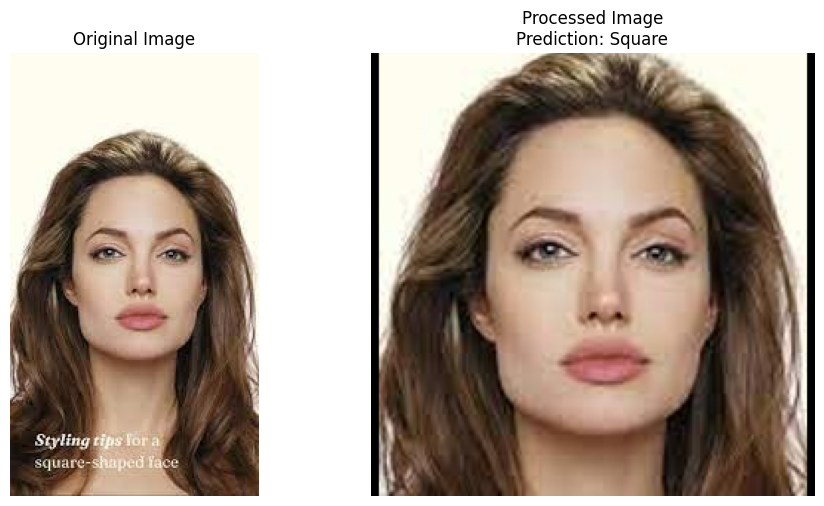

File sementara 'squarex.jpeg' telah dihapus.


In [80]:
if model is not None and detector is not None:
    print("\n===================================================")
    print(" MEMULAI SESI UNGGAH DAN PREDIKSI GAMBAR BARU ")
    print("===================================================")

    # Path ke file shape_predictor_68_face_landmarks.dat
    predictor_path = 'shape_predictor_68_face_landmarks.dat'

    # Periksa apakah file predictor ada sebelum memanggil fungsi
    if os.path.exists(predictor_path):
        upload_and_predict_colab(model, class_labels, detector, predictor_path, target_size)
    else:
        print(f"\nError: File predictor '{predictor_path}' tidak ditemukan.")
        print("Tidak dapat melanjutkan. Pastikan predictor sudah diunduh dan diekstrak dengan benar.")

else:
    print("\nModel atau Detektor dlib tidak berhasil dimuat/diinisialisasi.")
    print("Tidak dapat melanjutkan ke proses unggah dan prediksi.")
    print("Silakan periksa pesan error pada bagian inisialisasi di atas.")